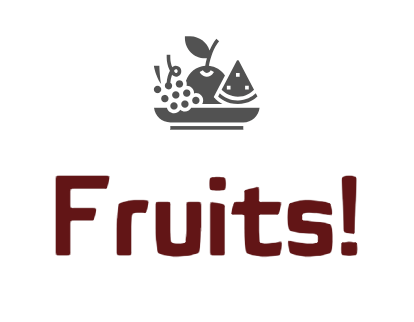

# Projet 8 : Déployez un modèle dans le cloud

### Démarrage de la session Spark

In [ ]:
# L'exécution de cette cellule démarre l'application Spark

<u>Affichage des informations sur la session en cours et liens vers Spark UI</u> :

In [3]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
2,application_1679919322198_0003,pyspark,idle,Link,Link,None,✔
4,None,pyspark,starting,,,None,


### Installation des packages

Les packages nécessaires ont été installé via l'étape de **bootstrap** à l'instanciation du serveur.

### Import des librairies

In [3]:
%matplotlib inline

In [100]:
import pandas as pd
import numpy as np
import io
from io import StringIO
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split,size
import matplotlib.pyplot as plt
import boto3
from pyspark.ml.feature import PCA, VectorAssembler, StandardScaler
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### 4.10.4 Définition des PATH pour charger les images et enregistrer les résultats

Nous accédons directement à nos **données sur S3** comme si elles étaient **stockées localement**.

In [54]:
PATH = 's3://bukcket-sarah-harouni'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
PATH_ACP = PATH+'/ACP'


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Traitement des données

#### Chargement des données

In [57]:
images = spark.read.format("binaryFile")\
.option("pathGlobFilter","*.jpg")\
.option("recursiveFileLookup","true")\
.load(PATH_Data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
images.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|s3://bukcket-sara...|2023-03-18 15:39:53|125135|[FF D8 FF E0 00 1...|
|s3://bukcket-sara...|2023-03-18 15:38:20|124785|[FF D8 FF E0 00 1...|
|s3://bukcket-sara...|2023-03-18 15:35:02|123514|[FF D8 FF E0 00 1...|
|s3://bukcket-sara...|2023-03-18 15:45:14|122958|[FF D8 FF E0 00 1...|
|s3://bukcket-sara...|2023-03-18 15:35:04|122807|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+
only showing top 5 rows

<u>Je ne conserve que le **path** de l'image et j'ajoute <br />
    une colonne contenant les **labels** de chaque image</u> :

In [59]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+------------------------------------------------------+-----------+
|path                                                  |label      |
+------------------------------------------------------+-----------+
|s3://bukcket-sarah-harouni/Test/apple_hit_1/r0_115.jpg|apple_hit_1|
|s3://bukcket-sarah-harouni/Test/apple_hit_1/r0_119.jpg|apple_hit_1|
|s3://bukcket-sarah-harouni/Test/apple_hit_1/r0_107.jpg|apple_hit_1|
|s3://bukcket-sarah-harouni/Test/apple_hit_1/r0_143.jpg|apple_hit_1|
|s3://bukcket-sarah-harouni/Test/apple_hit_1/r0_111.jpg|apple_hit_1|
+------------------------------------------------------+-----------+
only showing top 5 rows

None

#### Préparation du modèle

In [60]:
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [61]:
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
brodcast_weights = sc.broadcast(new_model.get_weights())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
new_model.summary()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [64]:
def model_fn():
    """
    La fonction retourne un modèle MobileNetV2 sans la dernière couche et 
    initialise les poids du nouveau modèle
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Création des fonctions pour le traitement des images

In [65]:
def preprocess(content):
    """
    Ouverture des images avec Pillow
    Changement de la taille des images
    Conversion de l'image en tableau numpy avec Keras
    Normalisation pour être utilisé avec MobileNetV2
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

def featurize_series(model, content_series):
    """
    Pré-traitement des images avec la fonction preprocess
    Calcul des caractéristiques de chaque image renvoyé sous forme de tableau Numpy
    Conversion des tableaux numpy en vecteur à une dimension
    Retourne les vecteurs au format Pandas Series
    
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    Fonction UDF de type "Scalar Iterator" qui prend en entrée un itérateur de séries de données Pandas
    et renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
    '''
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Extractions de features

In [67]:
# Création d'un Dataframe Spark dans lequel les images ont été réparties en 24 partitions
features_df = images.repartition(24).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
features_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+
|                path|               label|            features|
+--------------------+--------------------+--------------------+
|s3://bukcket-sara...|         apple_hit_1|[0.04273232, 0.40...|
|s3://bukcket-sara...|         apple_hit_1|[0.5164357, 0.466...|
|s3://bukcket-sara...|         apple_hit_1|[0.07671988, 0.54...|
|s3://bukcket-sara...|         apple_hit_1|[0.06957789, 0.25...|
|s3://bukcket-sara...|         apple_hit_1|[0.38415226, 0.73...|
|s3://bukcket-sara...|         apple_hit_1|[0.003768043, 0.5...|
|s3://bukcket-sara...|         apple_hit_1|[1.2212551, 0.569...|
|s3://bukcket-sara...|         apple_hit_1|[0.7043866, 0.580...|
|s3://bukcket-sara...|         apple_hit_1|[0.35329372, 0.40...|
|s3://bukcket-sara...|     cabbage_white_1|[0.0, 1.2717667, ...|
|s3://bukcket-sara...|              pear_3|[0.46841124, 0.12...|
|s3://bukcket-sara...|              pear_3|[1.43994, 0.13040...|
|s3://bukcket-sara...|app

In [71]:
# Créatin d'une fonction UDF qui prend en entrée un tableau numpy et renvoie un objet Vector dense
array_to_vector_udf = udf(lambda a: Vectors.dense(a),VectorUDT())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
# Application de la fonction pour obtenir une colonne avec les vecteurs denses
features_df= features_df.withColumn("features",array_to_vector_udf('features').alias("features_udf"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [73]:
features_df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+
|                path|               label|            features|
+--------------------+--------------------+--------------------+
|s3://bukcket-sara...|         apple_hit_1|[0.04273232072591...|
|s3://bukcket-sara...|         apple_hit_1|[0.51643568277359...|
|s3://bukcket-sara...|         apple_hit_1|[0.07671988010406...|
|s3://bukcket-sara...|         apple_hit_1|[0.06957788765430...|
|s3://bukcket-sara...|         apple_hit_1|[0.38415226340293...|
|s3://bukcket-sara...|         apple_hit_1|[0.00376804289408...|
|s3://bukcket-sara...|         apple_hit_1|[1.22125506401062...|
|s3://bukcket-sara...|         apple_hit_1|[0.70438659191131...|
|s3://bukcket-sara...|         apple_hit_1|[0.35329371690750...|
|s3://bukcket-sara...|     cabbage_white_1|[0.0,1.2717666625...|
|s3://bukcket-sara...|              pear_3|[0.46841123700141...|
|s3://bukcket-sara...|              pear_3|[1.43993997573852...|
|s3://bukcket-sara...|app

**Normalisation des données**

In [74]:
# création du modèle StandardScaler de normalisation des données 
scaler = StandardScaler(inputCol='features',outputCol="scaled_features",
                       withStd=True, withMean=True)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [75]:
# Entrainement de StandardScaler
scaler_model = scaler.fit(features_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [78]:
# Création d'une nouvelle colonne contenant les vecteurs denses normalisés
features_df = scaler_model.transform(features_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [79]:
features_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+--------------------+--------------------+
|                path|      label|            features|     scaled_features|
+--------------------+-----------+--------------------+--------------------+
|s3://bukcket-sara...|apple_hit_1|[0.04273232072591...|[-0.7550912307353...|
|s3://bukcket-sara...|apple_hit_1|[0.51643568277359...|[0.35762747895965...|
|s3://bukcket-sara...|apple_hit_1|[0.07671988010406...|[-0.6752552062379...|
|s3://bukcket-sara...|apple_hit_1|[0.06957788765430...|[-0.6920315883792...|
|s3://bukcket-sara...|apple_hit_1|[0.38415226340293...|[0.04689665560243...|
+--------------------+-----------+--------------------+--------------------+
only showing top 5 rows

**Réduction de dimensions : ACP**

In [1]:
# Création d'un premier modèle afin de calculer l'éboulis des valeurs propres
pca = PCA(k=260,inputCol='scaled_features', outputCol='acp_features')
pca_model = pca.fit(features_df)

NameError: name 'PCA' is not defined

In [85]:
# Calcul de la variance et de la variance cumulée
variance = pca_model.explainedVariance*100
variance_cum = variance.cumsum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [86]:
# Création d'un graphique représentant l'éboulis de valeurs propres et déterminer le nombre optimal de dimensions
plt.figure(figsize=(8,6))
plt.bar(np.arange(len(variance))+1, variance)
plt.plot(np.arange(len(variance))+1, variance_cum,marker='o')
plt.xlabel('Nombre de dimensions')
plt.ylabel('Variance cumulee')
#plt.axhline(y=80, linestyle="--", color='red')
plt.axvline(x=110, linestyle="--",color='red')

#plt.axhline(y=90, linestyle="--", color='green')
plt.axvline(x=240, linestyle="--",color='green')
plt.title('Eboulis des Valeurs propres', size=14)

plt.show(block=False)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

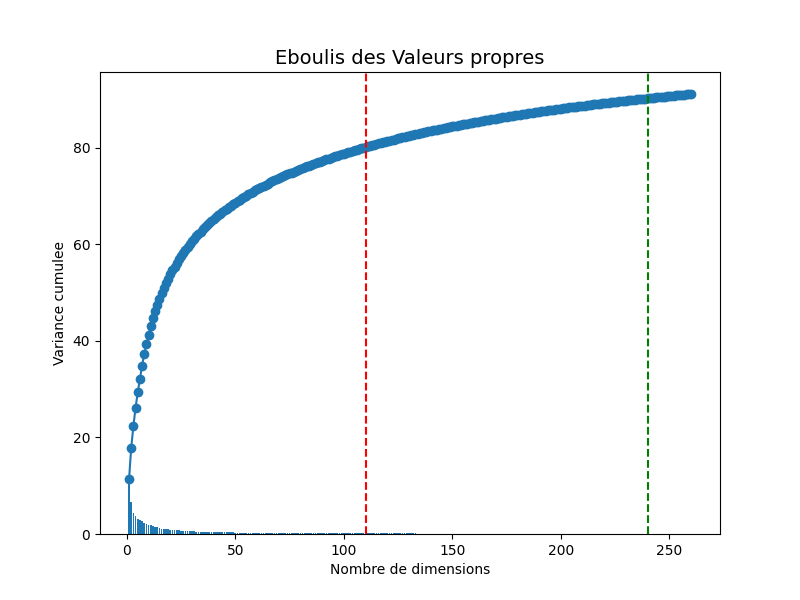

In [87]:
# Affichage du graphique
%matplot plt

In [88]:
# Création d'une nouvelle ACP avec le nombre optimal de dimensions
pca = PCA(k=240,inputCol='scaled_features', outputCol='acp_features')
pca_model = pca.fit(features_df)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [89]:
# Application de l'ACP et création d'une colonne qui contient les features après réduction de dimensions
df_acp = pca_model.transform(features_df)
df_acp.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                path|               label|            features|     scaled_features|        acp_features|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|s3://bukcket-sara...|         apple_hit_1|[0.04273232072591...|[-0.7550912307353...|[10.2274004582988...|
|s3://bukcket-sara...|         apple_hit_1|[0.51643568277359...|[0.35762747895965...|[11.2217082731905...|
|s3://bukcket-sara...|         apple_hit_1|[0.07671988010406...|[-0.6752552062379...|[2.58926596420020...|
|s3://bukcket-sara...|         apple_hit_1|[0.06957788765430...|[-0.6920315883792...|[0.90395136701822...|
|s3://bukcket-sara...|         apple_hit_1|[0.38415226340293...|[0.04689665560243...|[6.93633958363870...|
|s3://bukcket-sara...|         apple_hit_1|[0.00376804289408...|[-0.8466174566963...|[3.36577555325548...|
|s3://bukcket-sara...|         apple_

In [92]:
# Enregistrement des résultats au format parquet sur mon bucket s3 
df_acp.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [93]:
acp_features = df_acp.select('acp_features')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [94]:
acp_features.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|        acp_features|
+--------------------+
|[12.9661373497668...|
|[4.09447986151681...|
|[12.1525279134662...|
|[-1.2262317691197...|
|[17.3248514738366...|
|[3.13010287977758...|
|[2.00717464339533...|
|[2.43388202614744...|
|[0.34505393422889...|
|[17.2826310419571...|
|[-0.9910282397077...|
|[-2.4529997514154...|
|[-4.9610359894363...|
|[-4.1244061648190...|
|[-6.3931604107979...|
|[-8.0274828651921...|
|[10.5549490373607...|
|[-6.9869931750813...|
|[14.9125504619640...|
|[-10.841139720418...|
+--------------------+
only showing top 20 rows

In [97]:
acp_pandas = df_acp.toPandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [101]:
csv_buffer = StringIO()
acp_pandas.to_csv(csv_buffer,index=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
# Enregistrement des features au format .csv
s3 = boto3.resource('s3')
bucket_name = 'bukcket-sarah-harouni'
file_name = 'acp.csv'
s3.Object(bucket_name, file_name).put(Body=csv_buffer.getvalue())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ResponseMetadata': {'RequestId': 'WFRHY350RW7S9SS1', 'HostId': 'a+obRIPvML+FP17bHVC7mDA33VvlYBEiAgBfSoMgFuHmtmf7coh0SGFQlFq16y7ZwiXHmGqd4BQ=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'a+obRIPvML+FP17bHVC7mDA33VvlYBEiAgBfSoMgFuHmtmf7coh0SGFQlFq16y7ZwiXHmGqd4BQ=', 'x-amz-request-id': 'WFRHY350RW7S9SS1', 'date': 'Fri, 24 Mar 2023 12:05:27 GMT', 'x-amz-server-side-encryption': 'AES256', 'etag': '"a143515ade0774903a343b8987d6ad45"', 'server': 'AmazonS3', 'content-length': '0'}, 'RetryAttempts': 1}, 'ETag': '"a143515ade0774903a343b8987d6ad45"', 'ServerSideEncryption': 'AES256'}

### Chargement des données enregistrées et validation du résultat

In [103]:
df = spark.read.parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [104]:
df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------------+--------------------+--------------------+--------------------+
|                path|          label|            features|     scaled_features|        acp_features|
+--------------------+---------------+--------------------+--------------------+--------------------+
|s3://bukcket-sara...|    apple_hit_1|[0.64964246749877...|[0.67052726709144...|[7.01459077646239...|
|s3://bukcket-sara...|    apple_hit_1|[0.21089342236518...|[-0.3600845260581...|[7.70893746637701...|
|s3://bukcket-sara...|    apple_hit_1|[0.23257224261760...|[-0.3091614572526...|[8.26860332613512...|
|s3://bukcket-sara...|    apple_hit_1|[0.00204775761812...|[-0.8506583687225...|[2.97551605074360...|
|s3://bukcket-sara...|    apple_hit_1|[1.01796746253967...|[1.53571452575623...|[8.97628523163491...|
|s3://bukcket-sara...|cabbage_white_1|[0.0,0.9804180860...|[-0.8554685060303...|[5.35334511739833...|
|s3://bukcket-sara...|cabbage_white_1|[0.0,0.4506610929...|[-0.8554685060303...|[8